In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pyro

import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

## Vector-bandit
Assume there are $U$ users and $I$ items. Each are represented by a $d$ dimensional vector. All the vectors are normalized.

Given that you show item i to user u, the probability that u will click is $X^T_u Y_i$.

We implement the environment 

In [2]:
class ClickProbEnv():
    def __init__(self, d = 10, U = 10, I = 10, batch_size = 4):
        self.batch_size = batch_size
        self.U = U
        self.I = I
        self.d = d
        X = torch.rand(U,d) - 0.5
        self.X = X/X.norm(2,1,keepdim=True)
        Y = torch.rand(I,d) - 0.5
        self.Y = Y/Y.norm(2,1,keepdim=True)
        
    def click_prob(self, u, i):
        return torch.max(torch.tensor(0.0),((self.X[u,]*self.Y[i,]).sum(dim= 1, keepdim=True)))
    
    def step(self, u, i):
        p = self.click_prob(u,i)
        return (torch.rand((len(u),1)) <= p).float()
    
    def get_users(self, bs = None):
        if bs is None:
            bs = self.batch_size
        return torch.randint(self.U, (bs,)).long()


## Visualization of the model in a two dimensional space
They are all placed in a unit ball since we normalize the vectors.

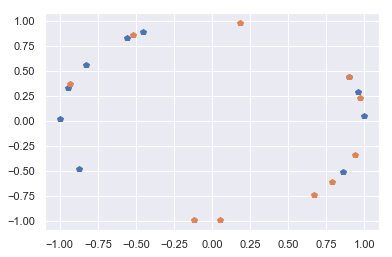

In [3]:
env = ClickProbEnv(d = 2)
plt.plot(env.X.numpy()[:,0], env.X.numpy()[:,1], "p")
plt.plot(env.Y.numpy()[:,0], env.Y.numpy()[:,1], "p")

# Case 1: Contextual
Let us build a high dimensional complex environment:

In [4]:
env = ClickProbEnv(U = 100, I = 100, d = 10)
steps = 1000 # number of steps in each game
evals = 100 # During evaluation, how many times should we evaluate the bandit?

###  Finding average click probabilities per action
Just as a benchmark. If we knew what arm to pull, what would our average reward be?  
A simple evaluation to find the average reward per action:

The best policy without user knowledge is to execute arm 32. Average reward is then 0.18252462148666382


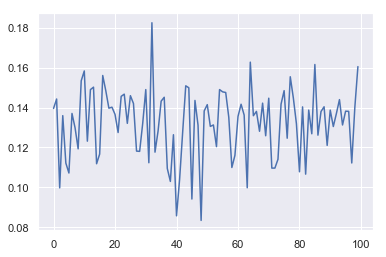

In [5]:
best_actions = [np.mean([env.click_prob(env.get_users(1),item) for _ in range(500)]) for item in range(env.I)]
plt.plot(best_actions)
print('The best policy without user knowledge is to execute arm {}. Average reward is then {}'.format( np.argmax(best_actions),max(best_actions)))

## Matrix Factorization
we let the bernoulli-agent do an epsilon greedy search with different epsilon parameters

In [6]:
from torch import nn
import torch

class MatrixFactorization(nn.Module):
    def __init__(self, U, I, dim = 5):
        super(MatrixFactorization, self).__init__()
        self.U = U
        self.I = I
        self.dim = dim
        self.item_emb = nn.Embedding(self.I, self.dim)
        self.user_emb = nn.Embedding(self.U, self.dim)
    def forward(self, users, items):
        uservec = self.user_emb(users)
        itemvec = self.item_emb(items)
        score = (uservec*itemvec).sum(dim=1, keepdim =True)
        return score
    
    def argmax(self, users):
        uservec = self.user_emb(users)
        itemvec = self.item_emb.weight.permute(1,0)
        scores = uservec.matmul(itemvec)
        best_action = scores.argmax(dim=1, keepdim=True)
        return best_action

In [7]:
#####################
### REPLAY MEMORY ###
#####################

from collections import namedtuple
import random
Transition = namedtuple('Transition',
                        ('user', 'action', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    


In [8]:
def get_batch(bs = 16):
    transitions = memory.sample(bs)
    batch = Transition(*zip(*transitions))
    sample = {
        'user' : torch.cat(batch.user).view(-1,1),
        'action' : torch.cat(batch.action).view(-1,1),
        'reward' : torch.cat(batch.reward).view(-1,1)
        }
    return sample

In [9]:
def play_eps_game(ep = 0.05):
    # Sample user
    user = env.get_users(bs=1)

    # Select action:
    if np.random.rand() > ep:
        action = mf.argmax(user)[0]
    else:
        action = torch.randint(low = 0, high=env.I, size = (1,)).long()

    reward = env.step(user, action.view(-1))

    memory.push(user, action, reward)
    return reward.squeeze()

In [10]:
def train_batch():
    batch = get_batch()
    yhat = mf(users = batch['user'].view(-1), items = batch['action'].view(-1))
    loss = criterion(yhat,batch['reward'])
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss.data

### Train

In [11]:
steps = 20000
evals = 10

In [12]:
losses = {}

In [13]:
for eps in [0.05,0.1,0.5, 0.8]:
    loss_series = np.zeros((evals,steps))
    for t in range(evals):
        memory = ReplayMemory(5000)
        mf = MatrixFactorization(env.U, env.I,dim=10)
        criterion = nn.MSELoss()
        optim = torch.optim.Adam(mf.parameters(),lr=0.1)

        r = torch.zeros(steps)
        loss = torch.zeros(steps)

        #warmup:
        for _ in range(20):
            play_eps_game(1.0)

        for i in range(steps):
            r[i] = play_eps_game(eps)
            loss[i] = train_batch()


        phat = r.cumsum(0)/torch.arange(1,steps+1).float()
        cum_avg_reward = (r.cumsum(0)/torch.arange(len(r)).float()).numpy()
        loss_series[t,:] = cum_avg_reward
    losses['eps_{}'.format(eps)] = {'reward_mean' : loss_series.mean(0), 'reward_std' : loss_series.std(0)}

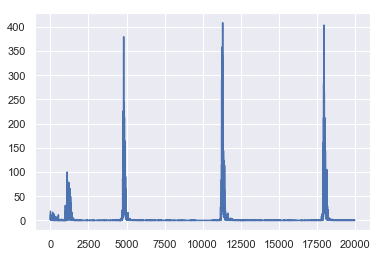

In [14]:
plt.plot(loss.numpy())

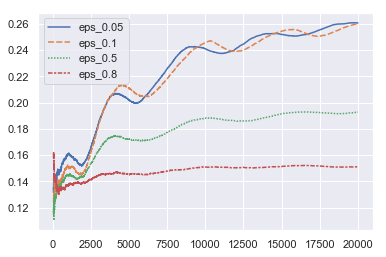

In [15]:
dat = pd.DataFrame({key : val['reward_mean'] for key, val in losses.items()})
sns.lineplot(data=dat[50:])

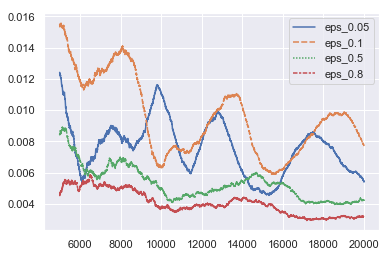

In [16]:
dat = pd.DataFrame({key : val['reward_std'] for key, val in losses.items()})
sns.lineplot(data=dat[5000:])


#### Performance of best epsilon

In [17]:
losses = {}
ep = 0.05
loss_series = np.zeros((evals,steps))
for t in range(evals):
    memory = ReplayMemory(5000)
    mf = MatrixFactorization(env.U, env.I,dim=10)
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(mf.parameters(),lr=0.1)

    r = torch.zeros(steps)
    loss = torch.zeros(steps)

    #warmup:
    for _ in range(20):
        play_eps_game(1.0)

    for i in range(steps):
        r[i] = play_eps_game(eps)
        loss[i] = train_batch()


    phat = r.cumsum(0)/torch.arange(1,steps+1).float()
    cum_avg_reward = (r.cumsum(0)/torch.arange(len(r)).float()).numpy()
    loss_series[t,:] = cum_avg_reward
    
losses['eps_{}'.format(eps)] = {'reward_mean' : loss_series.mean(0), 'reward_std' : loss_series.std(0)}

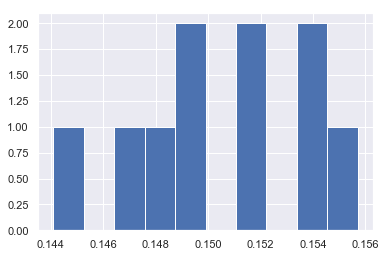

In [18]:
_ = plt.hist(loss_series[:,-1])

## Same model but with some noisy information about users